In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import category_encoders as ce # импорт для работы с кодировщиком

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# импортируем библиотеки для анализа тональности отзывов
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
nltk.downloader.download('vader_lexicon')

from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import chi2 # хи-квадрат
from sklearn.feature_selection import f_classif # anova

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# Project 3. Построение модели, которая предсказывает рейтинг отеля #

## Какой кейс решаем? ##
Представьте, что вы работаете дата-сайентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.

## Загрузка данных
Загрузим данные, удостоверимся, что все файлы открываются и изучим первоначальную метрику данных.

In [4]:
# Подгрузим наши данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [6]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [8]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [9]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


## Удаление дубликатов

In [10]:
# Проверем есть ли дубликаты в df_train

dupl_columns = list(df_train.columns)
mask = df_train.duplicated(subset=dupl_columns)
data_duplicates = df_train[mask]
print(f'Число найденных дубликатов: {data_duplicates.shape[0]}')

Число найденных дубликатов: 307


In [11]:
# удаляем найденные дубликаты

df_train.drop_duplicates(inplace=True)

In [12]:
# Объединяем трейн и тест в один датасет

df_train['sample'] = 1 # помечаем где у нас трейн
df_train['id'] = df_train.index
df_test['sample'] = 0 # помечаем где у нас тест
df_test['id'] = df_test.index
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_train.copy()
data = pd.concat([df_train,df_test],axis=0,ignore_index=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 19 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

Видим, что в столбцах lat и lng есть пропущенные данные.

## Заполнение пропущенных данных

In [13]:
data['hotel_address'].head(15)

0     Stratton Street Mayfair Westminster Borough Lo...
1     130 134 Southampton Row Camden London WC1B 5AF...
2      151 bis Rue de Rennes 6th arr 75006 Paris France
3     216 Avenue Jean Jaures 19th arr 75019 Paris Fr...
4             Molenwerf 1 1014 AG Amsterdam Netherlands
5                    Via Mecenate 121 20138 Milan Italy
6     97 Cromwell Road Kensington and Chelsea London...
7     Josefsgasse 4 6 08 Josefstadt 1080 Vienna Austria
8     190 Queen s Gate Kensington and Chelsea London...
9     Holland Park Avenue Kensington and Chelsea Lon...
10            Molenwerf 1 1014 AG Amsterdam Netherlands
11    34 44 Barkston Gardens Kensington and Chelsea ...
12    16 Sumner Place Kensington and Chelsea London ...
13    97 Cromwell Road Kensington and Chelsea London...
14     Putget 68 Sarri St Gervasi 08023 Barcelona Spain
Name: hotel_address, dtype: object

In [14]:
# выделим в адресе почтовый индекс, чтобы по нему восстановить координаты отелей
def zip_info(str):
    words = str.split()
    country = words[-1]
    if country == 'Kingdom' or country == 'Netherlands':
        zip_code = words[-4] + words[-3]
    else:
        zip_code = words[-3]
    return zip_code

data['zip_code'] = data['hotel_address'].apply(zip_info)
data['zip_code'].nunique() # всегод уникальных индексов 601

601

In [15]:
# В каждом городе определим средние значения широты и долготы для конкретного индекса

zip_medians = data.groupby('zip_code')[['lat', 'lng']].median()

mask1 = data['lat'].isnull() # пустые значения
zip_nulls = data[mask1]['zip_code'].unique()
# заменяем пропущенные значения широты и долготы на медианные значения по почтовым индексам
for zip_code in zip_nulls:
    mask2 = data['zip_code'] == zip_code
    data.loc[mask1 & mask2, 'lat'] = zip_medians.loc[zip_code, 'lat']
    data.loc[mask1 & mask2, 'lng'] = zip_medians.loc[zip_code, 'lng']

# проверяем, что пропущенных значений не осталось
data['lat'].isnull().mean()
data['lng'].isnull().mean()

# удалим столбец с индексами
data.drop(['zip_code'], axis=1, inplace=True)

## Проектирование признаков

In [16]:
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
object_columns # проверяем, какие колонки нам надо преобразовать

['hotel_address',
 'review_date',
 'hotel_name',
 'reviewer_nationality',
 'negative_review',
 'positive_review',
 'tags',
 'days_since_review']

In [17]:
# извлечение из адреса отеля страны
def adress_info(str):
    words = str.split()
    country = words[-1]
    if country == 'Kingdom':
        country = words[-2] + words[-1]
    else:
        country = words[-1]
    return country

data['country'] = data['hotel_address'].apply(adress_info)
data['country'].nunique() # 6 уникальных значений стран, позднее данный столбец закодируем

6

In [18]:
# преобразуем столбец с датой в datetime и извлечем несколько новых признаков
data['review_date'] = pd.to_datetime(data['review_date'])

data['review_day'] = data['review_date'].dt.day
data['review_month'] = data['review_date'].dt.month
data['review_year'] = data['review_date'].dt.year

data.drop(['review_date'], axis=1, inplace=True)

#data.info()

In [19]:
# извлечем из столбца days_since_review количество дней и переведем в числовое значение

regex = '\d+'
data['days_since_review_int'] = data['days_since_review'].str.findall(regex).str.get(0).astype('int')
data.drop(['days_since_review'], axis=1, inplace=True) # сразу удалим старые значения

#data.info()

In [20]:
# проанализируем тональность позитивных и негативных отзывов

sent_analyzer = SentimentIntensityAnalyzer()

data['positiv_sentiment'] = data['positive_review'].apply(lambda x: 
    sent_analyzer.polarity_scores(x)['compound'])
data['negativ_sentiment'] = data['negative_review'].apply(lambda x: 
    sent_analyzer.polarity_scores(x)['compound'])

# создадим столбец, который будет давать итоговую информацию по позитивным и негативным отзывам
data['pos_neg_review'] = data['positiv_sentiment'] + data['negativ_sentiment']

# и удалим лишние столбцы
data.drop(['positive_review', 'negative_review'], axis=1, inplace=True)
data.drop(['positiv_sentiment', 'negativ_sentiment'], axis=1, inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 21 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   average_score                               515431 non-null  float64
 3   hotel_name                                  515431 non-null  object 
 4   reviewer_nationality                        515431 non-null  object 
 5   review_total_negative_word_counts           515431 non-null  int64  
 6   total_number_of_reviews                     515431 non-null  int64  
 7   review_total_positive_word_counts           515431 non-null  int64  
 8   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 9   reviewer_score                              515431 non-null  float64
 

In [21]:
# для начала изучим содержание столбца тегов

data['tags'].explode().value_counts().index

# чтоб использовать эти данные в машинном обучении  и предсказании, извечем из тэгов количество ночей,
# на которое останавливались постояльцы

Index(['[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']',
       '[' Leisure trip ', ' Couple ', ' Standard Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']',
       '[' Leisure trip ', ' Couple ', ' Superior Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']',
       '[' Leisure trip ', ' Couple ', ' Deluxe Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']',
       '[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']',
       '[' Leisure trip ', ' Couple ', ' Superior Double Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']',
       '[' Leisure trip ', ' Couple ', ' Standard Double Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']',
       '[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 1 night ']',
       '[' Leisure trip ', ' Couple ', ' Standard Double Room ', ' Stayed 1 ni

In [22]:
# для работы со столбцом с тэгами преобразуем строку в список
def tags_to_list(str_tags):
    str_tags = str_tags[2:-2]
    list_tags = str_tags.strip().split(' \', \' ')
    return list_tags

data['tags_list'] = data['tags'].apply(tags_to_list)
data['tags_list'].head(10)

0    [Leisure trip, Couple, Studio Suite, Stayed 2 ...
1    [Business trip, Couple, Standard Double Room, ...
2    [Leisure trip, Solo traveler, Modern Double Ro...
3    [Leisure trip, Solo traveler, Standard Room wi...
4    [Business trip, Couple, Standard Double or Twi...
5    [Business trip, Solo traveler, Superior Twin R...
6    [Leisure trip, Couple, Double Room Non Smoking...
7    [Leisure trip, Couple, Superior Double Room, S...
8    [Leisure trip, Couple, Double Room, Stayed 1 n...
9    [Leisure trip, Couple, Twin Hilton Guest Room,...
Name: tags_list, dtype: object

In [23]:
# выделим количество ночей, указанных в тэгах
def nights_stay(tags_list):
    for tag in tags_list:
        words = tag.split()
        if words[0] =='Stayed':
            return int(words[1])
    return np.NaN # если данные не указаны, ставим NaN

data['nights_stay'] = data['tags_list'].apply(nights_stay)
data['nights_stay'].fillna(1, inplace=True) # не во всех тегах указано количество дней пребывания
# поэтому пустые значения заменяем на 1 ночь, так как это значение моды для данного признака
#data.info()

## Кодирование данных

In [24]:
# исследуем номинальный признак "национальность"

data['reviewer_nationality'].value_counts()

 United Kingdom               245165
 United States of America      35390
 Australia                     21663
 Ireland                       14820
 United Arab Emirates          10230
                               ...  
 Guinea                            1
 Tuvalu                            1
 Comoros                           1
 Anguilla                          1
 Cape Verde                        1
Name: reviewer_nationality, Length: 227, dtype: int64

In [25]:
# так как номинальных признаков больше 15, то используем бинарное кодирование

bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality'])
type_bin = bin_encoder.fit_transform(data['reviewer_nationality'])
data = pd.concat([data, type_bin], axis=1)

data.drop(['reviewer_nationality'], axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 30 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   average_score                               515431 non-null  float64
 3   hotel_name                                  515431 non-null  object 
 4   review_total_negative_word_counts           515431 non-null  int64  
 5   total_number_of_reviews                     515431 non-null  int64  
 6   review_total_positive_word_counts           515431 non-null  int64  
 7   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 8   reviewer_score                              515431 non-null  float64
 9   tags                                        515431 non-null  object 
 

In [26]:
# ранее мы узнали, что номинальных признаков "страна" 6, поэтому мы используем однократное кодирование

encoder = ce.OneHotEncoder(cols=['country'], use_cat_names=True)
type_bin = encoder.fit_transform(data['country'])
data = pd.concat([data, type_bin], axis=1)

data.drop(['country'], axis=1, inplace=True)
#data.info()

In [27]:
# закодируем название отелей методом двоичного кодирования

bin_encoder = ce.BinaryEncoder(cols=['hotel_name'])
type_bin = bin_encoder.fit_transform(data['hotel_name'])
data = pd.concat([data, type_bin], axis=1)

data.drop(['hotel_name'], axis=1, inplace=True)
#data.info()

## Удаление столбцов с не цифровыми данными

In [28]:
data.drop(['hotel_address', 'tags', 'tags_list'], axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 42 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515431 non-null  int64  
 1   average_score                               515431 non-null  float64
 2   review_total_negative_word_counts           515431 non-null  int64  
 3   total_number_of_reviews                     515431 non-null  int64  
 4   review_total_positive_word_counts           515431 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 6   reviewer_score                              515431 non-null  float64
 7   lat                                         515431 non-null  float64
 8   lng                                         515431 non-null  float64
 9   sample                                      515431 non-null  int64  
 

## Разделим данные

In [29]:
train_data = data[data['sample'] == 1]
test_data = data[data['sample'] == 0]
train_data.index = train_data['id']
test_data.index = test_data['id']

train_data.drop(['sample','id'],axis=1,inplace=True)
test_data.drop(['sample','id','reviewer_score'],axis=1,inplace=True)

train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 386496 entries, 0 to 386802
Data columns (total 40 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                386496 non-null  int64  
 1   average_score                               386496 non-null  float64
 2   review_total_negative_word_counts           386496 non-null  int64  
 3   total_number_of_reviews                     386496 non-null  int64  
 4   review_total_positive_word_counts           386496 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  386496 non-null  int64  
 6   reviewer_score                              386496 non-null  float64
 7   lat                                         386496 non-null  float64
 8   lng                                         386496 non-null  float64
 9   review_day                                  386496 non-null  int64  
 

/tmp/ipykernel_20/2911538065.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.drop(['sample','id'],axis=1,inplace=True)
/tmp/ipykernel_20/2911538065.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(['sample','id','reviewer_score'],axis=1,inplace=True)


## Разделим признаки на непрерывные и категориальные и оценим их важность

In [30]:
# непрерывные признаки

num_cols = ['average_score', 'pos_neg_review',
            'total_number_of_reviews', 'review_total_negative_word_counts', 
            'review_total_positive_word_counts', 
            'total_number_of_reviews_reviewer_has_given',
            'additional_number_of_scoring', 'days_since_review_int']

# категориальные признаки
cat_cols = ['review_day', 'review_month', 'review_year', 'lat', 'nights_stay']

<AxesSubplot: >

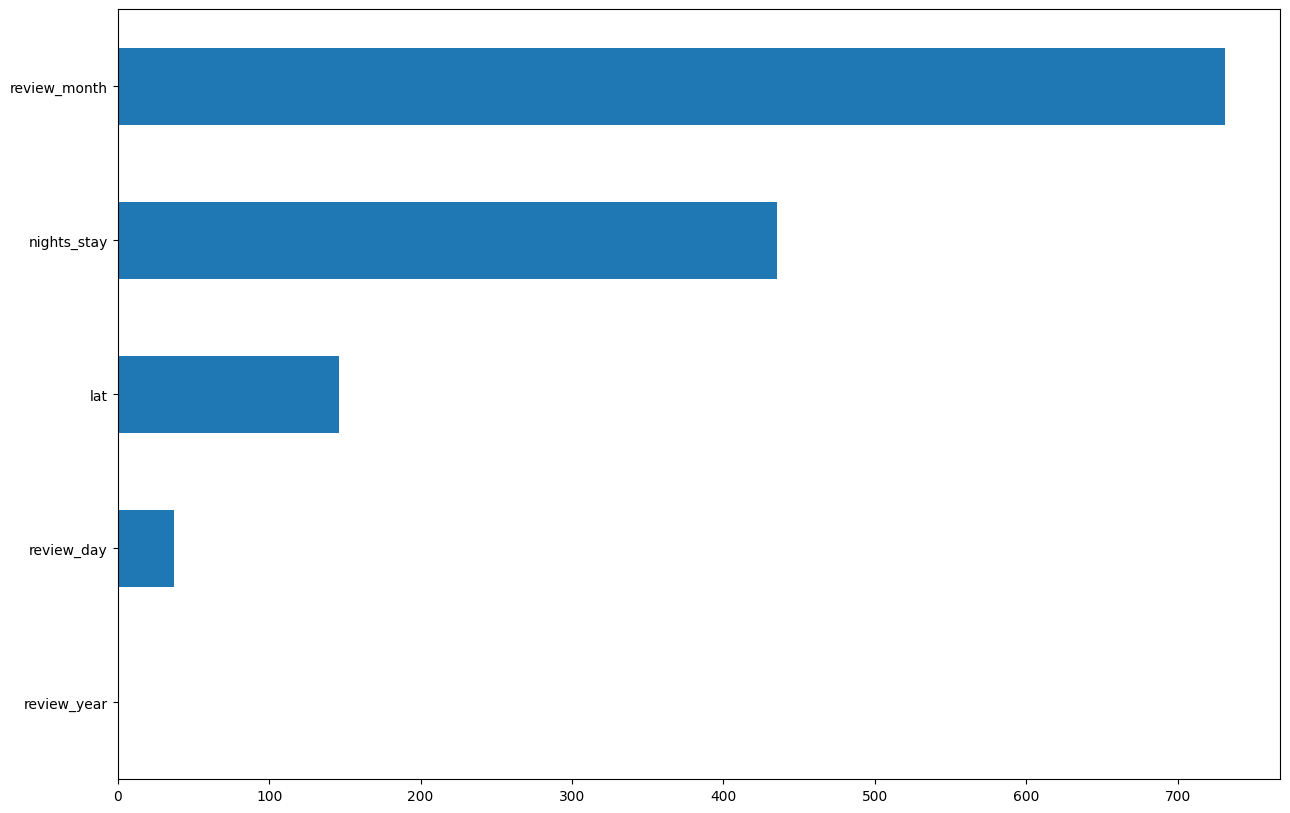

In [31]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  

X = train_data.drop(['reviewer_score'], axis = 1)  
y = train_data['reviewer_score'] 

y=y.astype('int')

# оценим влияние категориальных признаков

plt.rcParams['figure.figsize'] = (15,10)
imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [32]:
# удалим колонку с самым низким рейтингом


train_data.drop(['review_year'],axis=1, inplace=True)
test_data.drop(['review_year'],axis=1, inplace=True)

/tmp/ipykernel_20/2613048941.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.drop(['review_year'],axis=1, inplace=True)
/tmp/ipykernel_20/2613048941.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(['review_year'],axis=1, inplace=True)


<AxesSubplot: >

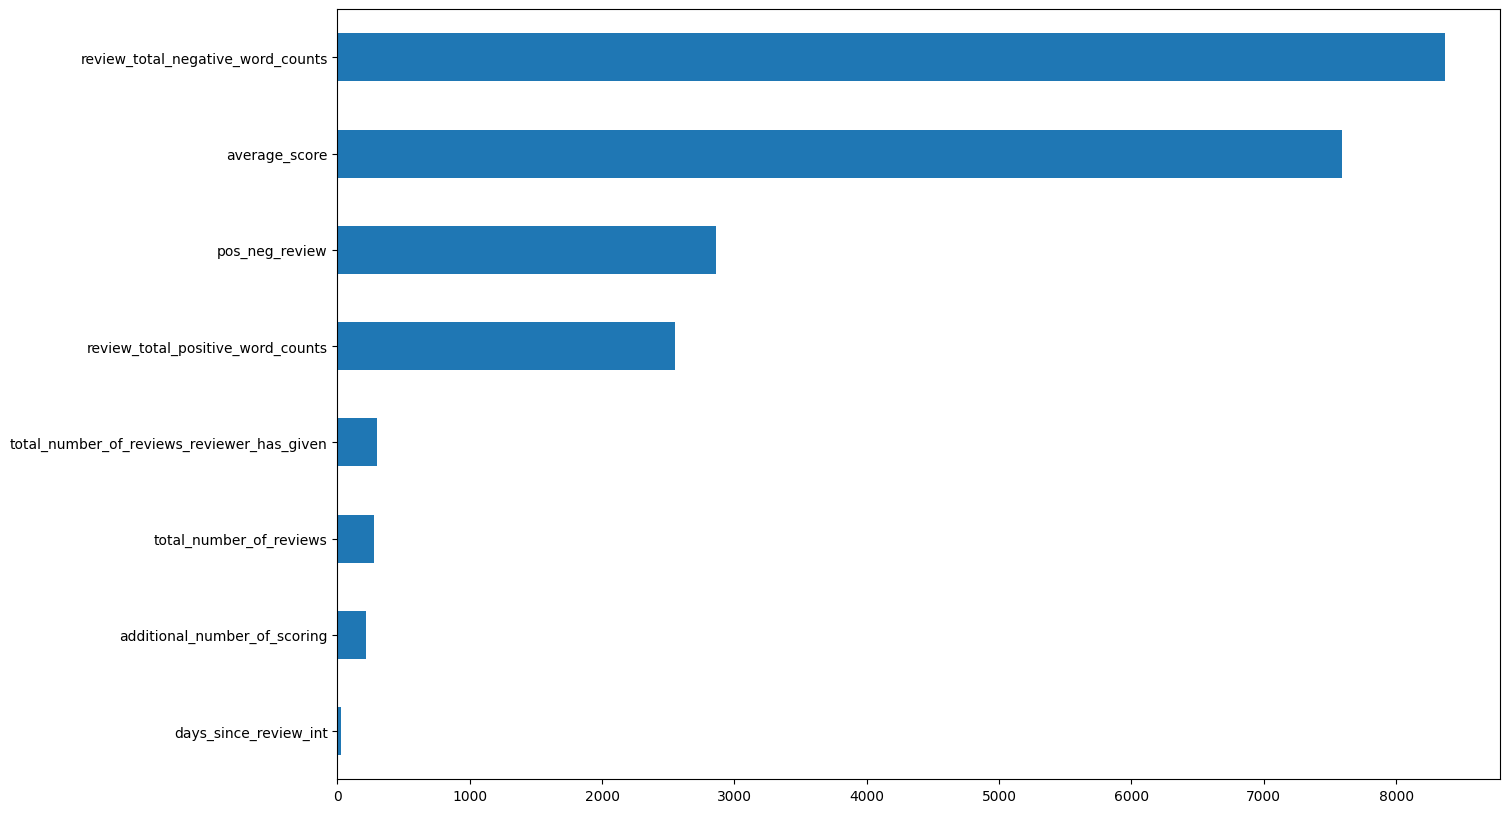

In [33]:
# оценим влияние числовых признаков

plt.rcParams['figure.figsize'] = (15,10)
imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [34]:
# удалим колонку с самым низким рейтингом

train_data.drop(['days_since_review_int'],axis=1, inplace=True)
test_data.drop(['days_since_review_int'],axis=1, inplace=True)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128935 entries, 0 to 128934
Data columns (total 37 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                128935 non-null  int64  
 1   average_score                               128935 non-null  float64
 2   review_total_negative_word_counts           128935 non-null  int64  
 3   total_number_of_reviews                     128935 non-null  int64  
 4   review_total_positive_word_counts           128935 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  128935 non-null  int64  
 6   lat                                         128935 non-null  float64
 7   lng                                         128935 non-null  float64
 8   review_day                                  128935 non-null  int64  
 9   review_month                                128935 non-null  int64  
 

/tmp/ipykernel_20/269725309.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.drop(['days_since_review_int'],axis=1, inplace=True)
/tmp/ipykernel_20/269725309.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(['days_since_review_int'],axis=1, inplace=True)


<AxesSubplot: >

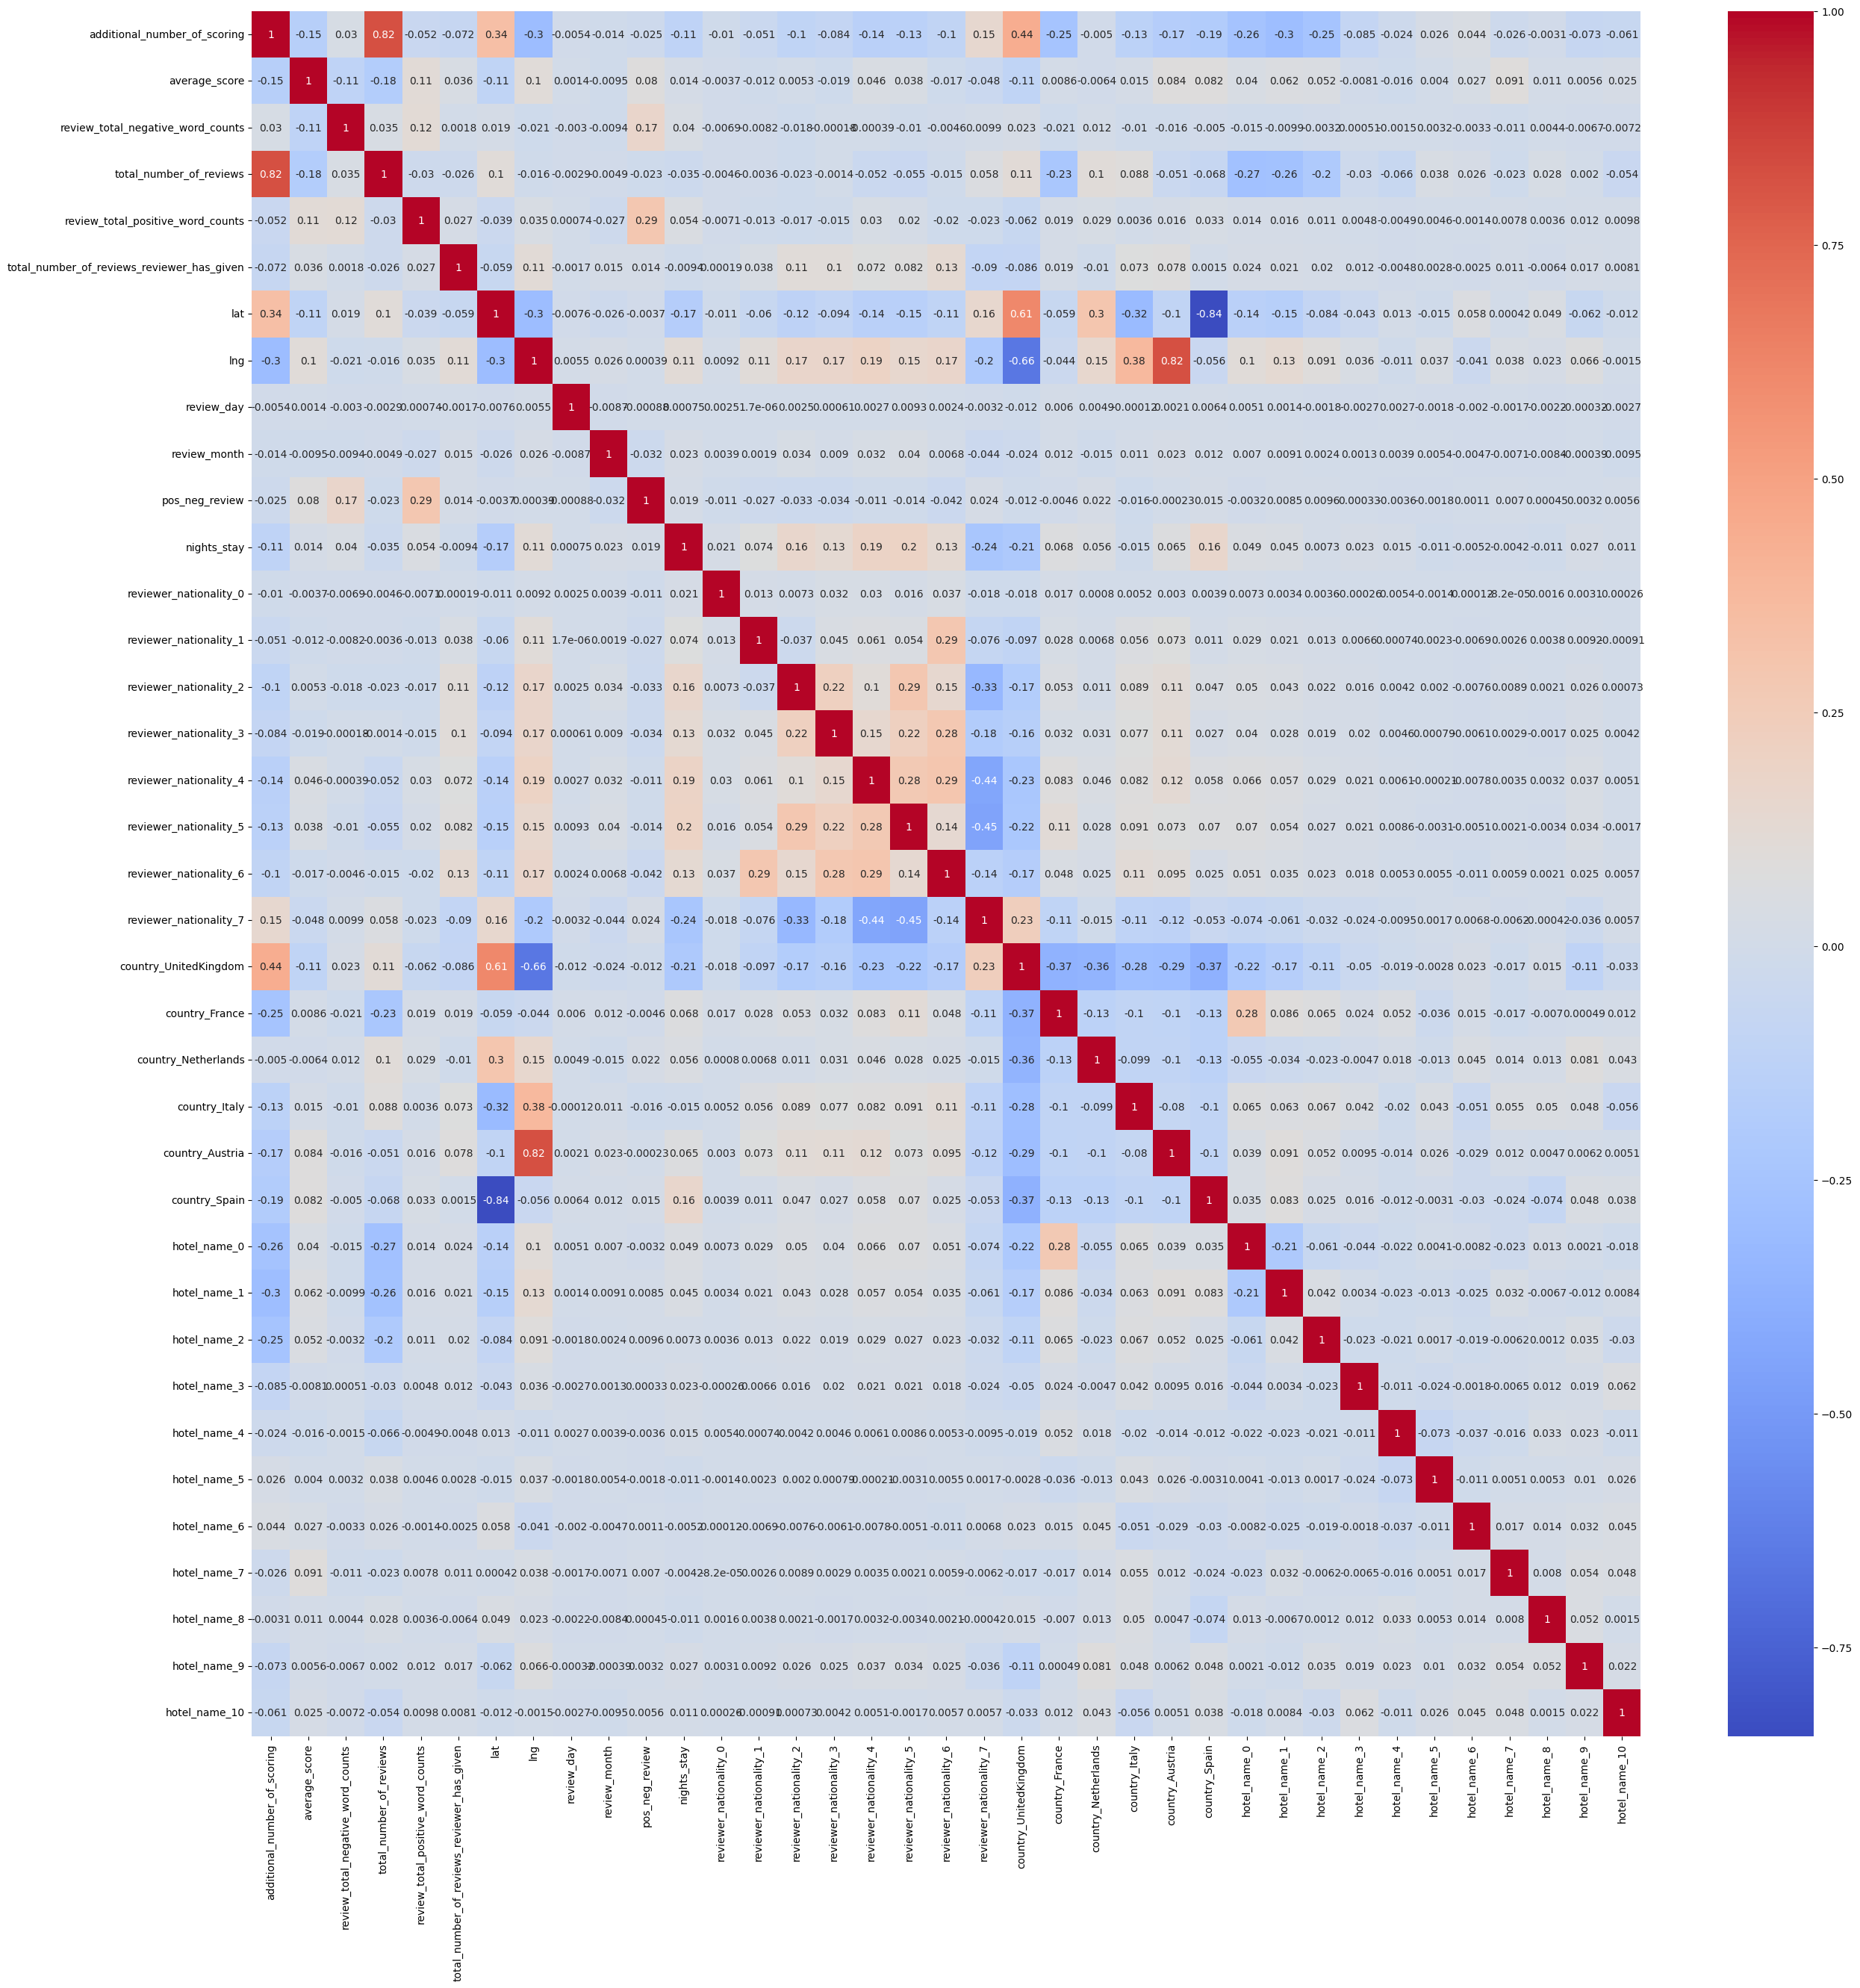

In [35]:
# оценим корреляцию оставшихся признаков

plt.rcParams['figure.figsize'] = (30,30)
sns.heatmap(train_data.drop('reviewer_score',axis=1).corr(), annot=True, cmap='coolwarm')

In [36]:
# удалим признаки с мультиколлинеарностью

train_data.drop(['additional_number_of_scoring'], axis=1, inplace=True)
test_data.drop(['additional_number_of_scoring'], axis=1, inplace=True)

/tmp/ipykernel_20/2007152121.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.drop(['additional_number_of_scoring'], axis=1, inplace=True)
/tmp/ipykernel_20/2007152121.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(['additional_number_of_scoring'], axis=1, inplace=True)


<AxesSubplot: >

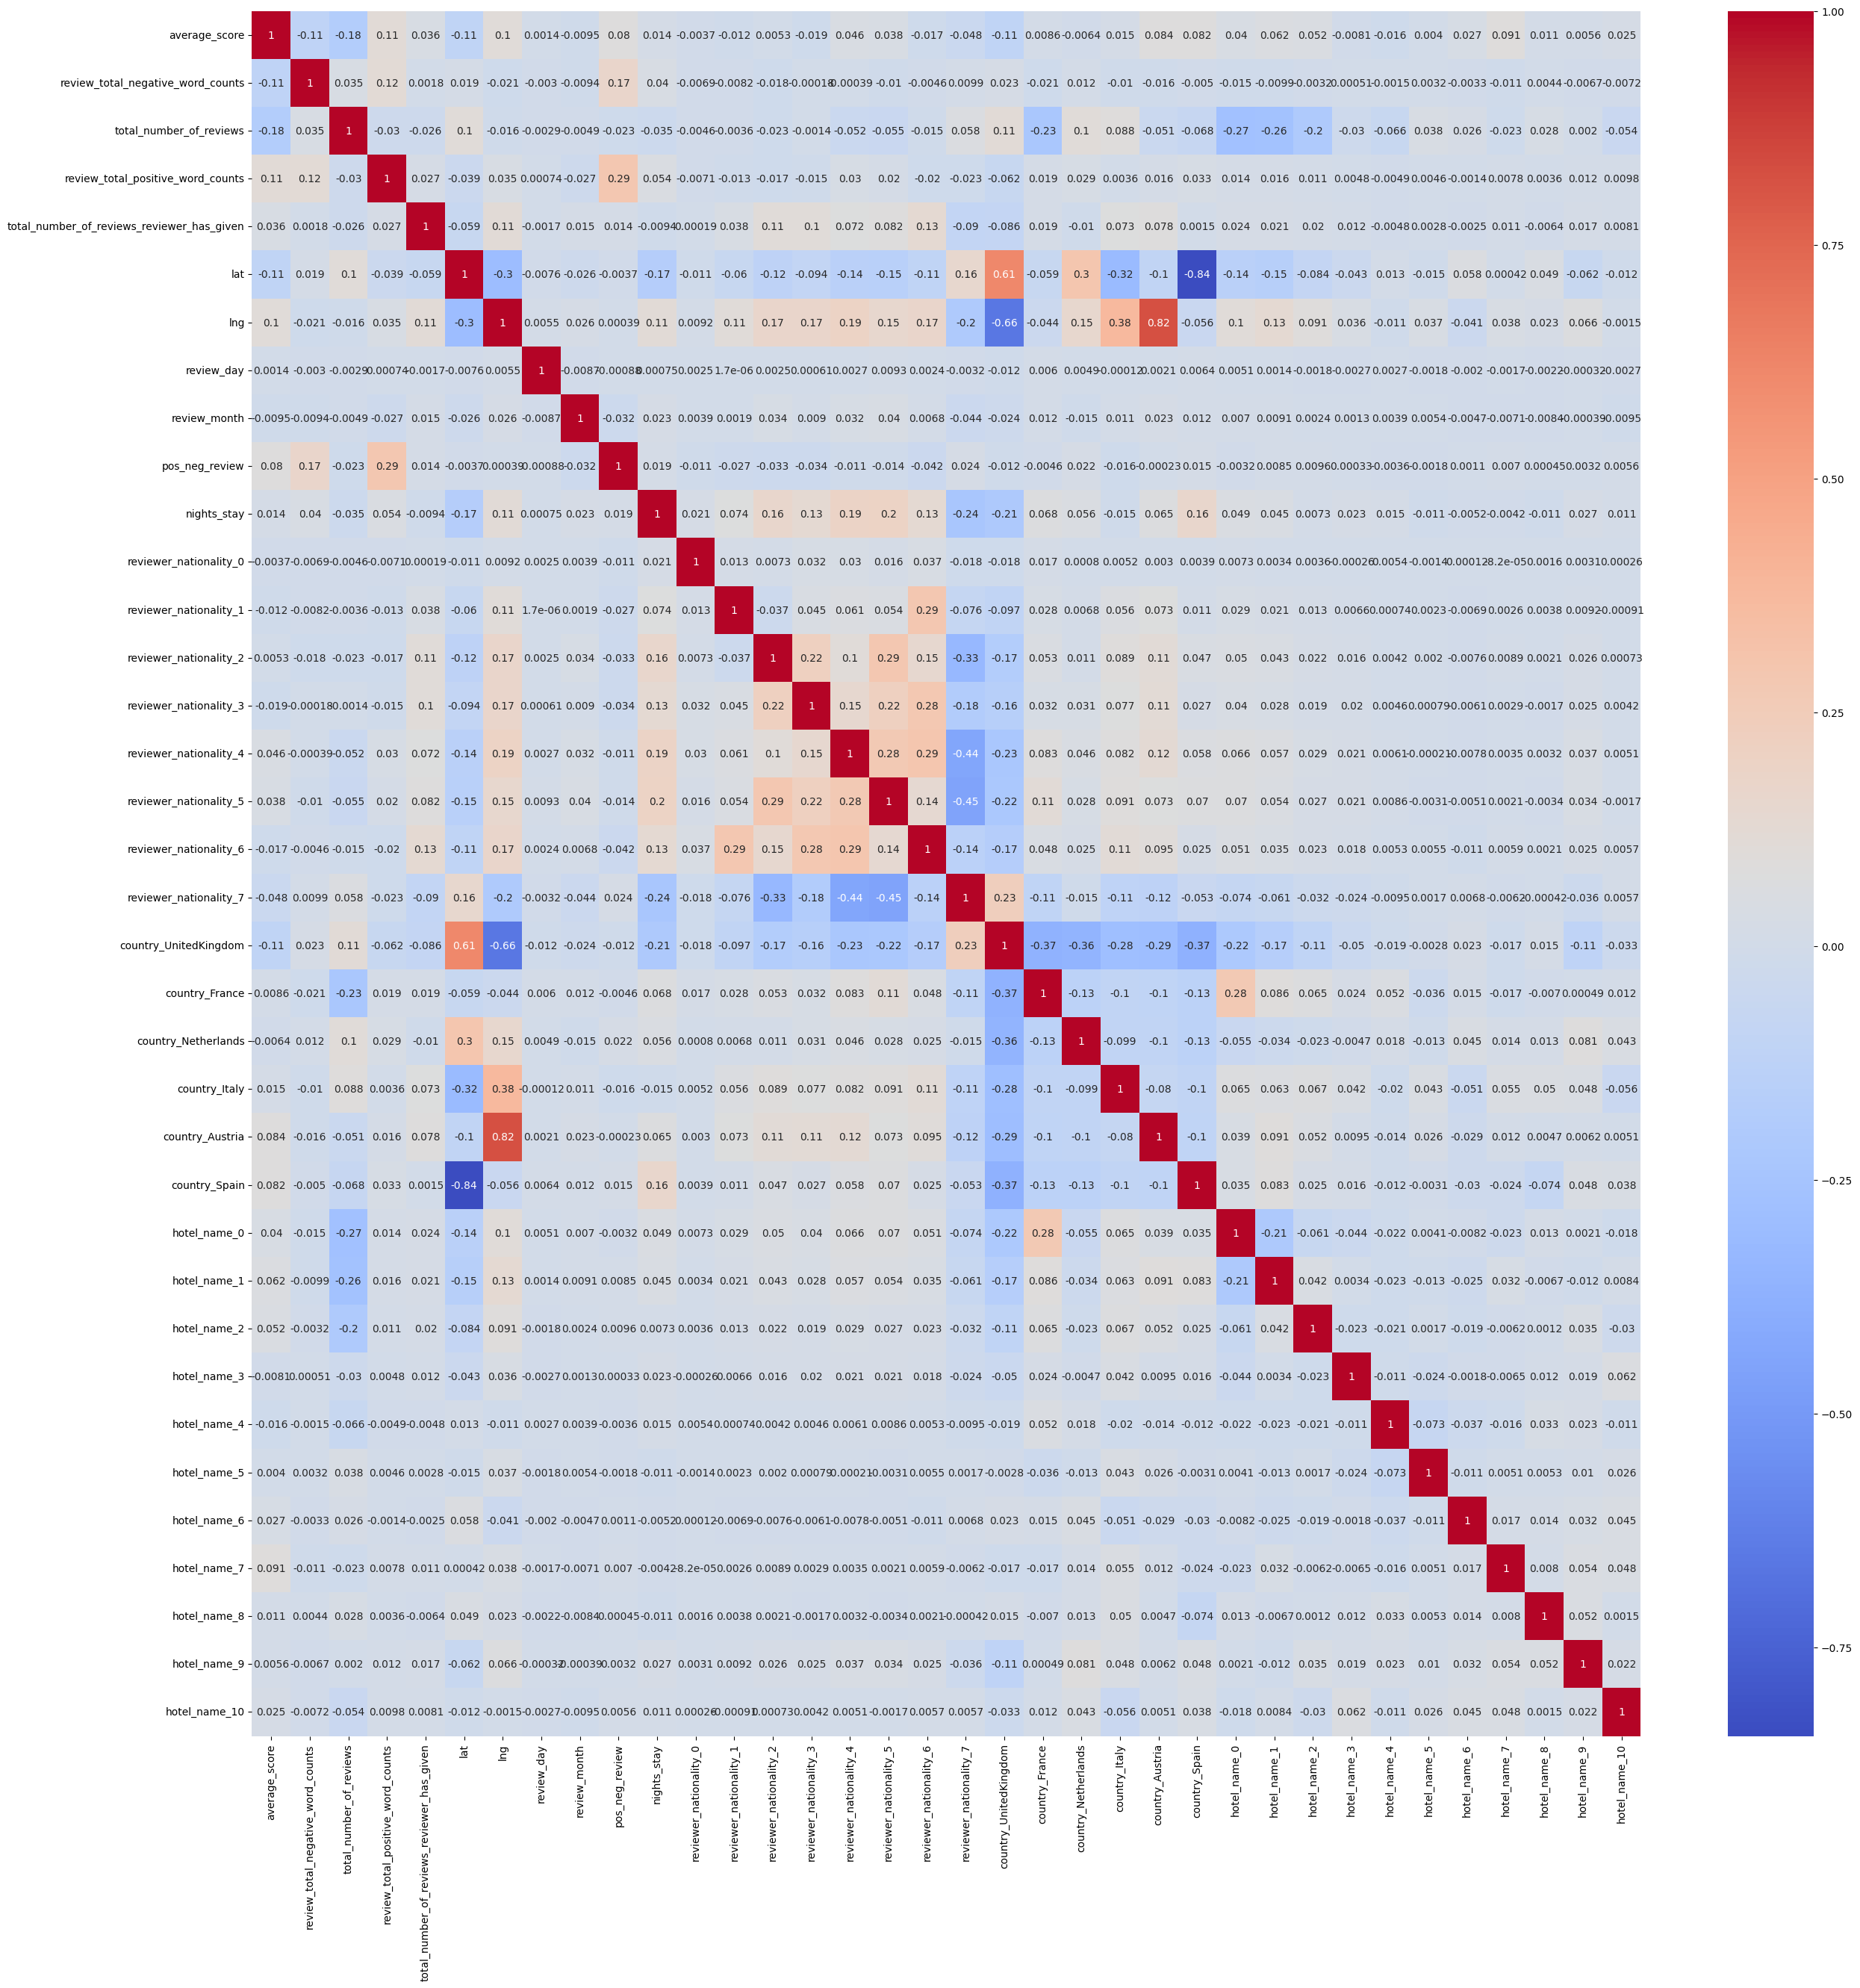

In [37]:
# проверим еще раз корреляцию

plt.rcParams['figure.figsize'] = (30,30)
sns.heatmap(train_data.drop('reviewer_score',axis=1).corr(), annot=True, cmap='coolwarm')

In [38]:
# видим, что еще сильную корреляцию создает столбец lng, удалим этот столбец и связанный с ним

train_data.drop(['lng', 'lat'], axis=1, inplace=True)
test_data.drop(['lng', 'lat'], axis=1, inplace=True)

/tmp/ipykernel_20/4248566436.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.drop(['lng', 'lat'], axis=1, inplace=True)
/tmp/ipykernel_20/4248566436.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(['lng', 'lat'], axis=1, inplace=True)


## Обучаем модель

In [39]:
# pазбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей) 

X = train_data.drop(['reviewer_score'], axis = 1)  
y = train_data.reviewer_score.values

# наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# проверяем размерности получившихся датасетов

print(test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape)

# создаём модель

RANDOM_SEED = 42
model = RandomForestRegressor(n_estimators=500, verbose=1, random_state=RANDOM_SEED, n_jobs=-1)  
      
# Обучаем модель на тестовом наборе данных

model.fit(X_train, y_train)  
      
# используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  

y_pred = model.predict(X_test)


# сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются.  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную
# ошибку предсказанных значений от фактических. 

print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

(128935, 34) (386496, 35) (386496, 34) (289872, 34) (96624, 34)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   59.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 11.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   10.0s


MAPE: 0.1275498631758997


[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   11.3s finished


<AxesSubplot: >

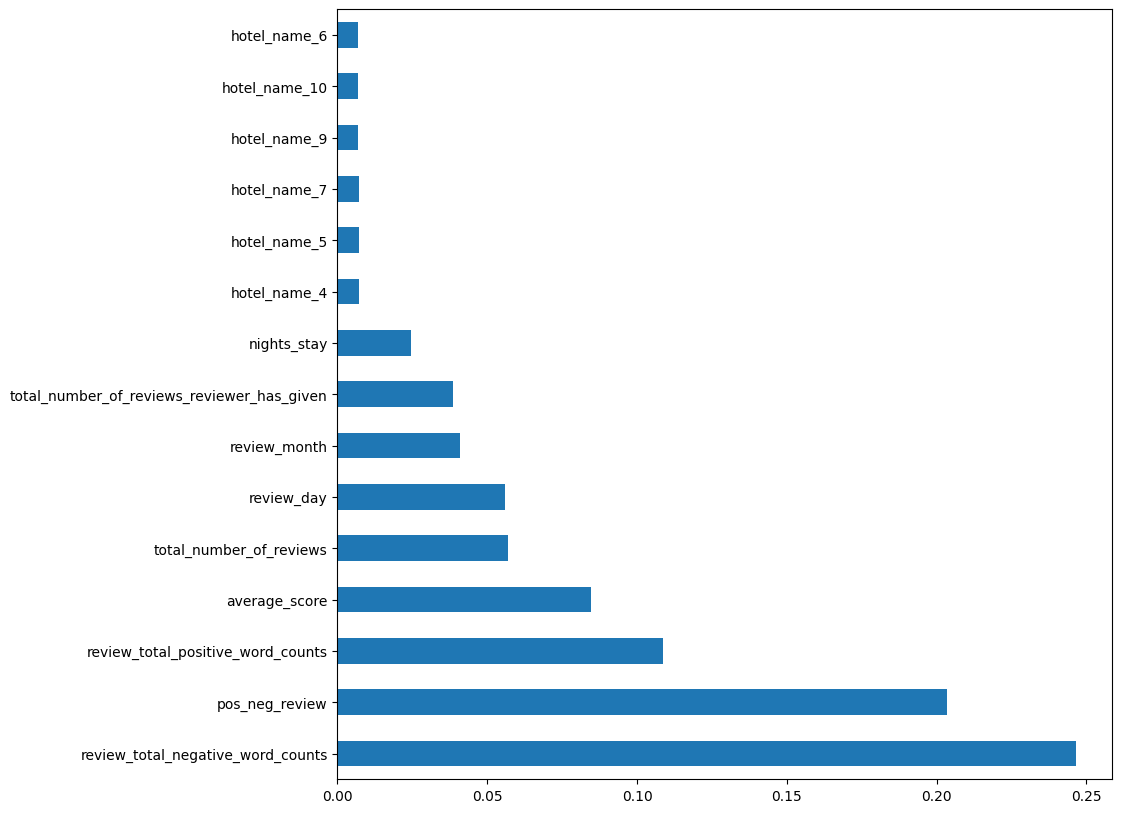

In [40]:
# выведем самые важные признаки для модели

plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

## Выполним предсказание

In [41]:
predict_submission = model.predict(test_data)

# сохраним в файл

sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index = False)
sample_submission.head(10)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   13.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   14.9s finished


,reviewer_score,id
0,8.6288,488440
1,7.4020,274649
2,8.1966,374688
3,9.7026,404352
4,9.6488,451596
5,9.2992,302161
6,8.5150,317079
7,8.1728,13963
8,8.5616,159785
9,8.2440,195089


In [42]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
